# Analyzing Revenue Data: Unveiling Insights into Customer Churn Rates in the First Two Years of Operation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Loading Data

In [2]:
address = "teleco_time_series.csv"

df = pd.read_csv(address, index_col='Day')
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


### Plotting Time Series
A visual representation of the time series

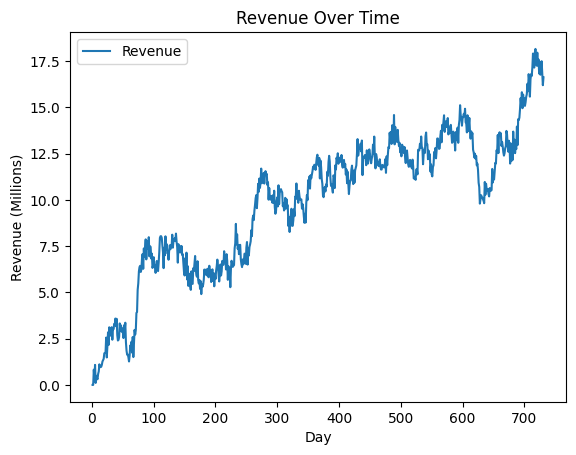

In [26]:
df.plot()
plt.title('Revenue Over Time')
plt.xlabel('Day')
plt.ylabel('Revenue (Millions)')
plt.legend()
plt.show()

### Checking for Gaps in Data
The time step for this series is in days. From the line graph above, there appears to be no missing values. A quick check of the length of df as well as a count of entries for the Revenue column of df provide the proof that there is no missing data in the data the time series. The length of df is 731 and the total Revenue entries is also 731.

In [4]:
len(df)

731

In [5]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


### Splitting Data: Training and Testing Sets
To split the dataset into training and testing sets, it was necessary to split them along sections of time. In this case, the decision was made to split it in half which resulted in the training set containing all revenue made in the first year of operation and the testing set containing all revenue made in the second year of operation.

In [6]:
# Train data - first year data
df_train = df.loc[:'366']

# Test data - second year data
df_test = df.loc['367':]

In [7]:
df_train.count()

Revenue    366
dtype: int64

In [8]:
df_test.count()

Revenue    365
dtype: int64

### Plotting Training and Testing Sets

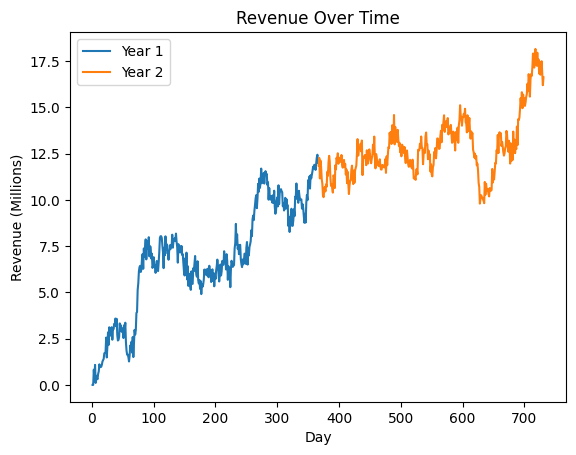

In [27]:
fig, ax = plt.subplots()
df_train.plot(ax=ax)
df_test.plot(ax=ax)

plt.title('Revenue Over Time')
plt.xlabel('Day')
plt.ylabel('Revenue (Millions)')

ax.legend(['Year 1', 'Year 2'])

plt.show()

### Checking for Stationarity
To determine if the time series was stationary, an Augmented Dicky-Fuller test was run and the results were analyzed. The ADF test statistic was determined to be -1.9246, with a p-value of 0.3206, and a critical value of -3.4394 for a 99% confidence rate. For the ADF statistic, the more negative, the more likely the data is to be stationary and it needed to be greater than the critical value. It was not. Additionally, the p-value was greater than 0.05 so the null hypothesis is accepted which states that the time series is non-stationary. (ARIMA Models in Python, n.d.)

In [10]:
# Run ADF test on the original time series  # (ARIMA Models in Python, n.d.)
result = adfuller(df['Revenue'])

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.4f' % (key, value)) # (Singh, Basic, 2020)

ADF Statistic: -1.9246121573101809
p-value: 0.32057281507939783
Critical Values:
	1%: -3.4394
	5%: -2.8655
	10%: -2.5689


### Create Lagged Data and Second Check for Stationarity
To create a stationary time series, the difference can be taken and then that can be tested with the ADF test to determine how many differences are required to make the series stationary. The difference was taken once, the NaN values were dropped, and a new dataframe was created called revenue_stationary. This new dataframe was then run through the ADF test, plotted for visual confirmation, and the test statistic and p-values were analyzed. 

This second ADF test and associated line graph indicate that using the lagged data resulted in a stationary dataset. This can be seen in the test statistic, p-value, and critical values above. The more negative a test statistic (in this case it is -44.87), the more likely the data is to be stationary. 

Additionally, a p-value smaller than 0.05 allows us to reject the null hypothesis, which is to say, reject that this data is non-stationary. Lastly, the critical values indicate what the test statistic should be based on how certain we wanted (99% certain, 95% certain, or 90% certain). In all cases, with a p-value of 0.0, the test statistic needed to be a minimum of -3.439. The test statistic was even more negative than that at -44.87. 

All of this combined to provide solid evidence that the lagged data is now stationary and can thus be used to model the time series.(ARIMA Models in Python, n.d.)

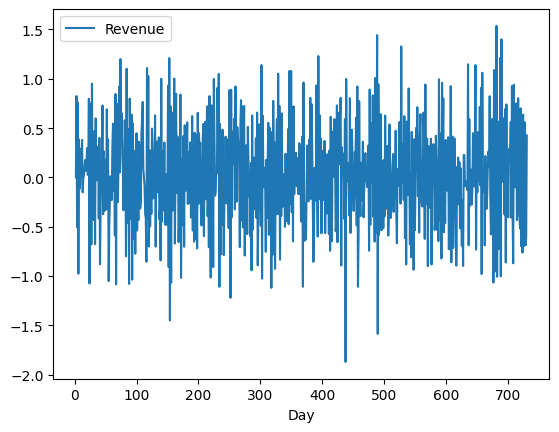

ADF Statistic: -44.874527193875984
p-value: 0.0
Critical Values:
	1%: -3.4394
	5%: -2.8655
	10%: -2.5689


In [11]:
# Calculate the difference of the time series
revenue_stationary = df.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(revenue_stationary['Revenue'])

# Plot the differenced time series
fig, ax = plt.subplots()
revenue_stationary.plot(ax=ax)
plt.show()         # (ARIMA Models in Python, n.d.)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.4f' % (key, value)) # (Singh, Basic, 2020)

## Determining Seasonal Component

### Selecting Period Size
In order to determine the period, the data needed to be de-trended. This is most easily accomplished by subtracting the rolling mean of N size of the dataframe from the dataframe. An N=25 was used but any large N will work. The de-trended data was then put into an autocorrelation plot. Any peak at a lag greater than 1 will be at whatever the period is for the data. In this case, every 1 lag had a peak indicating that this data has a period of 1. (ARIMA Models in Python, n.d.)

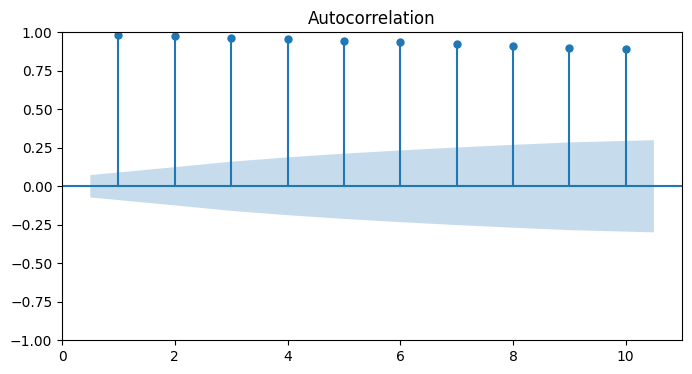

In [12]:
s_df = df - df.rolling(25).mean()

s_df = df.dropna()

fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(s_df, ax=ax, lags=10, zero=False)
plt.show()                                  # (ARIMA Models in Python, n.d.)

### Decomposed Time Series
The period size identified when plotting the de-trended df was 1. Using that as the period, the time series was decomposed into the following components. From the decomposed time series, the lack of seasonality is verified as well as the lack of trends in the residual plot.

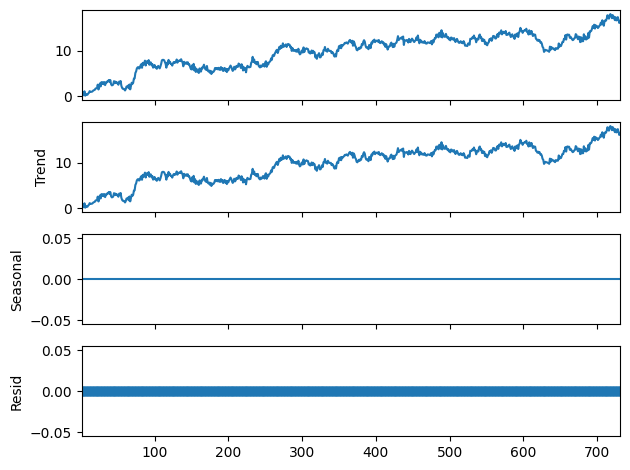

In [13]:
decomposed = seasonal_decompose(df,period=1, model='additive')

decomposed.plot()
plt.show()                       # (West, 2021)

### Auto-correlation Function
This plot indicates that the revenue of previous days impacts current revenue but the impact decreases with time. Lags after about 26 are not significant at all.

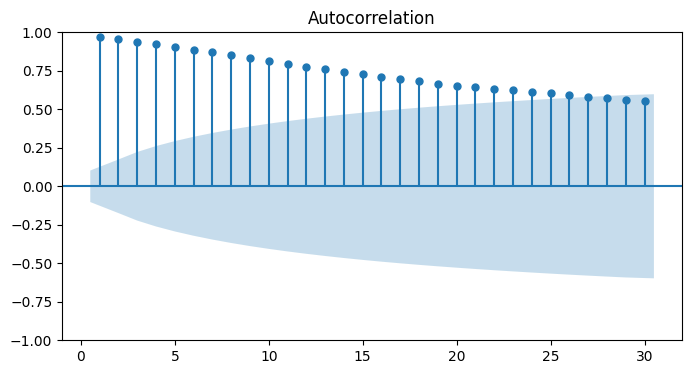

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(df_train, ax=ax, lags=30, zero=False)
plt.show()            # (West, 2021)

### Spectral Density Plot
The spectral density plot is a frequency characterization of the stationary time series (12.1 Estimating the Spectral Density: STAT 510, n.d.) 

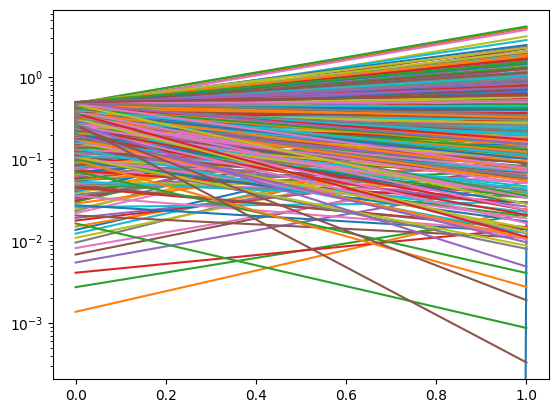

In [15]:
spectral_density = signal.periodogram(x=revenue_stationary['Revenue'], fs=1, scaling='density', window='blackman')

plt.semilogy(spectral_density);  # (Scipy.signal.periodogram, n.d.)

## Determine Model Order
### Plot ACF and PACF to determine best fit
The process for determining the best fit model was to plot the autocorrelation function and the partial autocorrelation function to see if model order could be established from these plots. These plots indicated that perhaps an appropriate model order would be an AR(2) but are inconclusive for ARIMA models so the next thing to do was to check best fit using AIC and BIC for a variety of different values. (ARIMA Models in Python, n.d.)

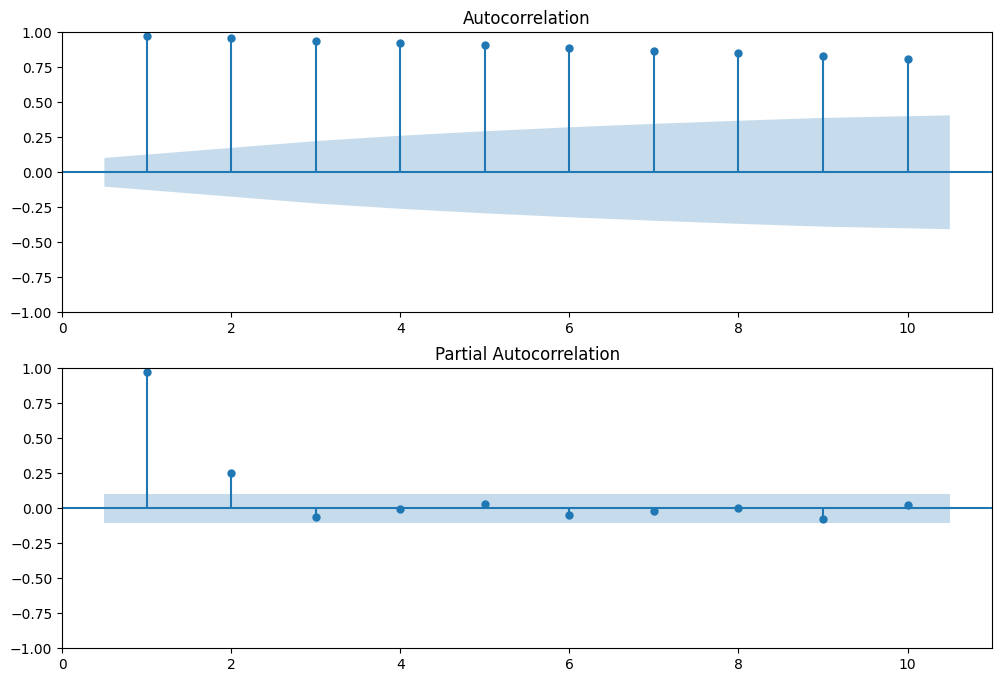

In [16]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of Revenue on ax1
plot_acf(df_train, lags=10, zero=False, ax=ax1)

# Plot the PACF of Revenue on ax2
plot_pacf(df_train, lags=10, zero=False, ax=ax2)

plt.show()             # (ARIMA Models in Python, n.d.)

### Use AIC and BIC to determine best fit
By using the Augmented Dicky-Fuller test, it was determined that in order for the data to be stationary, it needed to be differenced once. That result provided the d value of 1 for the ARIMA model. Then, using a range of 0-3 to iterate over the ARIMA model with order (p,1,q), 16 different models were created and compared. From these models, the p value was selected as 1 and the q value was selected as 0. A model order of (1,1,0) was selected for the analysis based upon having the lowest values for AIC and BIC, indicating best fit. (ARIMA Models in Python, n.d.)

In [17]:
# Create empty list to store search results
order_aic_bic=[]

# Define range for p and q values
p_range = range(4)
q_range = range(4)

# Loop over p and q values
for p in p_range:
    for q in q_range:
        # create and fit SARIMAX(p, 1, q) model
        model = SARIMAX(df_train, order=(p, 1, q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))
        
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df sorted by AIC in ascending order
print(order_df.sort_values('AIC'))    # (ARIMA Models in Python, n.d.)

    p  q         AIC         BIC
4   1  0  486.801219  494.601013
8   2  0  487.595600  499.295292
5   1  1  487.841069  499.540762
9   2  1  488.129496  503.729086
12  3  0  488.358896  503.958485
6   1  2  488.481702  504.081292
3   0  3  489.356942  504.956531
2   0  2  489.526903  501.226595
10  2  2  490.129496  509.628983
13  3  1  490.341163  509.840650
7   1  3  490.433828  509.933315
11  2  3  491.938165  515.337549
14  3  2  492.058623  515.458007
15  3  3  493.792262  521.091543
1   0  1  510.370882  518.170677
0   0  0  577.239206  581.139103


### ARIMA Model
The best fit for the ARIMA model was determined to be order=(1,1,0) based on the results of the AIC and BIC model comparisons.

In [18]:
# Create ARIMA(1,1,0) model
arima = SARIMAX(df_train, order=(1,1,0))

# Fit ARIMA model
arima_results = arima.fit()  # (ARIMA Models in Python, n.d.)

## Model Evaluation Procedure

### Test Statistics
The test statistics <code>Prob(Q)</code> and <code>Prob(JB)</code> from the model summary provide insight into model performance. <code>Prob(Q)</code> is the p-value for the null hypothesis that the residuals are uncorrelated. <code>Prob(JB)</code> is the p-value associated with the null hypothesis that the residuals are normally distributed. If either of these values is less than 0.05, we have to reject the null hypothesis.

For this model, the <code>Prob(Q)</code> is 0.77 and the <code>Prob(JB)</code> is 0.38. Both are greater than 0.05 so we accept the null hypothesis. This means that the residuals are uncorrelated and that they are normally distributed. (ARIMA Models in Python, n.d.)

In [19]:
# Print ARIMA summary
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  366
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -241.401
Date:                Sat, 01 Jul 2023   AIC                            486.801
Time:                        12:00:42   BIC                            494.601
Sample:                             0   HQIC                           489.901
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4727      0.047    -10.125      0.000      -0.564      -0.381
sigma2         0.2196      0.018     12.053      0.000       0.184       0.255
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.78   Prob(JB):                         0.38
Heteroskedasticity (H):               0.89   Skew:                            -0.01
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot Diagnostics
All four diagnostic plots indicate that the residuals of the model are performing as expected meaning they are uncorrelated white noise centered on zero. This is a great indication that the model will create accurate predictions and that no relevant information was left out of the model. (ARIMA Models in Python, n.d.)

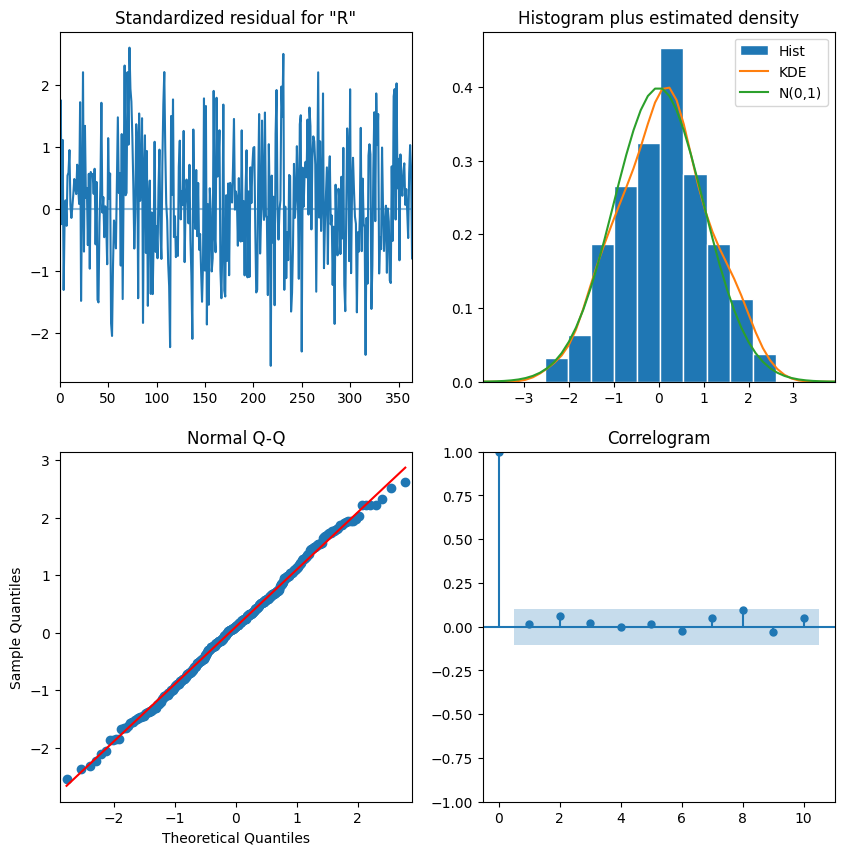

In [20]:
# Create the 4 diagnostic plots
arima_results.plot_diagnostics(figsize=(10,10))
plt.show()   # (ARIMA Models in Python, n.d.)

## Forecasting
### Forecasting Future Revenue
A forecast length equal to the total length of the testing dataset, 365, was selected as the forecast length. This allows for a 1:1 comparison of observed values from the data set to the forecasted values and for the mean absolute error to be calculated on the results.

In [21]:
# Make ARIMA forecast of next 365 values
forecast = arima_results.get_forecast(365)

# Print forecast
print(forecast.summary_frame())

Revenue       mean   mean_se  mean_ci_lower  mean_ci_upper
366      12.202842  0.468638      11.284328      13.121356
367      12.103120  0.529793      11.064745      13.141494
368      12.150261  0.635974      10.903776      13.396747
369      12.127976  0.704173      10.747822      13.508130
370      12.138511  0.775858      10.617857      13.659164
..             ...       ...            ...            ...
726      12.135129  6.053791       0.269918      24.000341
727      12.135129  6.062148       0.253537      24.016721
728      12.135129  6.070494       0.237180      24.033079
729      12.135129  6.078829       0.220844      24.049414
730      12.135129  6.087152       0.204531      24.065727

[365 rows x 4 columns]


### Forecast Plot

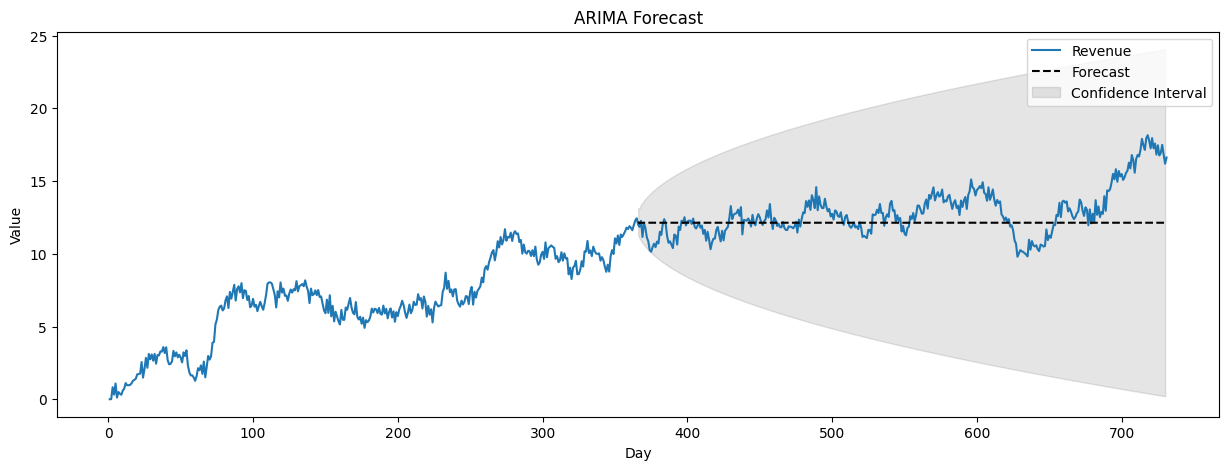

In [22]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the original data
df.plot(ax=ax)

# Add the forecasted values to the plot
fcast = forecast.summary_frame()
ax.plot(fcast.index, fcast['mean'], 'k--', label='Forecast')

# Shade the area between upper and lower confidence intervals
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'],
                color='k', alpha=0.1, label='Confidence Interval')

# Set the x-axis and y-axis labels
ax.set_xlabel('Day')
ax.set_ylabel('Value')

# Set the title and legend
ax.set_title('ARIMA Forecast')
ax.legend()
plt.show()

# (Forecasting in statsmodel, n.d.)

The above visualization is a plot of the training set, in blue, which consists of 365 observations. The dotted black line is the plot of the forecast, also equal to 365 observations. The gray area is the upper and lower bounds of the confidence intervals of the forecast, as calculated by the summary frame. The confidence intervals are set at an alpha of 0.1 which translates to 99% confidence level. From the confidence intervals it can be seen that the further out the forecast goes, the wider the range is between the upper bound and the lower bound of the confidence interval. It is more difficult to predict this far out without more data. 

### Calculate the Mean Absolute Error
The MAE is used to indicate how accurately the model makes predictions. For this model, the forecasted revenue values are on average 9.44% different from the actual revenue values in the test set. Based on these results, this is an accurate model for making forecasts.

In [23]:
# Calculate mean absolute error percentage
mae_percent = np.mean(np.abs((df_test['Revenue'].values - fcast['mean']) / df_test['Revenue'].values)) * 100

# Print mean absolute error with more context
print(f'The mean absolute error is {mae_percent:.2f}%')     # (Singh, Advanced, 2020)

The mean absolute error is 9.44%


## Recommendation
My recommended course of action based upon the results of this analysis is to gather more historical revenue data and use this trained ARIMA model to further analyze customer churn trends. From the first two years of operation, the trend for revenue is that overall, it increased despite some significant losses. These losses are most likely caused by a sudden increase in customer churn. This data did not have a seasonal component to it, but further exploration of more years can perhaps shed light on any cyclical decreases in customers. For now, I recommend continuing programs that have already been successful at reducing churn and to gather more time series data to use with this ARIMA model.

## Reference

12.1 Estimating the Spectral Density: STAT 510. (n.d.). Retrieved from https://online.stat.psu.edu/stat510/lesson/12/12.1

ARIMA Models in Python. (n.d.). Retrieved December 06, 2022, from https://app.datacamp.com/learn/courses/arima-models-in-python

Dotis-Georgiou, A. (2021, August 19). Autocorrelatio Dotis-Georgiou, A. (2021, August 19). Autocorrelation in Time Series Data. Retrieved from https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Forecasting in statsmodels. (n.d.). Retrieved from https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html

Scipy.signal.periodogram. (n.d.). Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html

Singh, D. (2020, May 15). Basic Time Series Algorithms and Statistical Assumptions in Python. Retrieved from https://www.pluralsight.com/guides/basic-time-series-algorithms-and-statistical-assumptions-in-python

Singh, D. (2020, June 04). Advanced Time Series Modeling (ARIMA) Models in Python. Retrieved from https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python

West, Z. (2021, July 27). Autocorrelation of Time Series Data in Python. Retrieved from https://www.alpharithms.com/autocorrelation-time-series-python-432909/
